# 0.a. Import and settings

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
from scanpy.plotting._tools.scatterplots import plot_scatter
import scanpy_scripts as ss
import bbknn

expr_cmap = ss.lib.expression_colormap(background_level=0.01)
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sc.settings.figdir = 'png'

# 0.b. Define functions

In [3]:
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def diffexp(
    adata, basis='umap', key=None, res=None, method='logreg',
    filter_params={'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 2},
    extra_genes=None, **kwargs
):
    if key:
        grp_key = f'{key}_r{str(res).replace(".", "_")}'
        basis=f'{basis}_{key}'
    else:
        grp_key = f'r{str(res).replace(".", "_")}'
    de_tbl = ss.lib.diffexp(
        adata, key_added=grp_key, groupby=f'leiden_{grp_key}', method=method,
        filter_params=filter_params, **kwargs,
    )
    de_genes = list(de_tbl.groupby('cluster').head(4)['genes'].values)
    if extra_genes:
        de_genes.extend(extra_genes)
    rcParams.update({'figure.figsize': (4,4)})
    sc.pl.rank_genes_groups(adata, key=f'rank_genes_groups_{grp_key}', show=False)

    sc.pl.dotplot(
        adata,
        var_names=de_genes,
        groupby=f'leiden_{grp_key}',
        #standard_scale='var',
        show=False
    )

    rcParams.update({'figure.figsize':(2.5,2.5)})
    plot_scatter(
        adata, basis=basis, color_map=expr_cmap, use_raw=True, ncols=8, size=10, color=de_genes, show=False)
    rcParams.update({'figure.figsize':(3,3)})
    ss.lib.plot_embedding(adata, basis=basis, groupby=f'leiden_{grp_key}', size=20, show=False)
    return de_tbl

# 1. Load data

In [5]:
CATEGORY_NAME = 'erythroid'
CATEGORY_CLUSTER_ID = 8
MIN_BATCH_SIZE = 10
DE_METHOD = 't-test_overestim_var'
DE_FILTERS = {'min_in_group_fraction': 0.4, 'max_out_group_fraction': 0.2, 'min_fold_change': 1.5}
KNOWN_MARKERS = ['HBA2']

In [6]:
# 1. Load data
fetal_ad = sc.read('data/h5ad/fetal_skin_raw.20190926.h5ad', mode='r')

# Restrict to category of interest
ad = fetal_ad[(fetal_ad.obs['hierarchy1'] == CATEGORY_CLUSTER_ID), :]

# Remove samples with too few cells
sample_sizes = ad.obs['sample'].value_counts()
valid_batches = sample_sizes[sample_sizes >= MIN_BATCH_SIZE].index.to_list()
ad = ad[ad.obs['sample'].isin(valid_batches), :]

ad.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}.h5ad', compression='gzip')

In [7]:
ad

AnnData object with n_obs × n_vars = 5508 × 33694 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1'
    var: 'gene_ids', 'cc'

# 2. QC

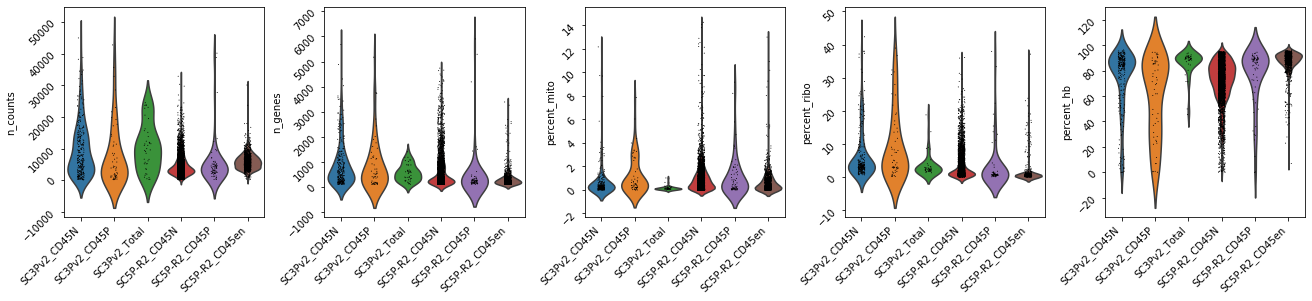

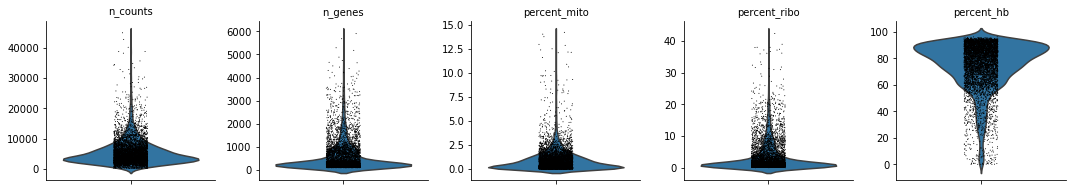

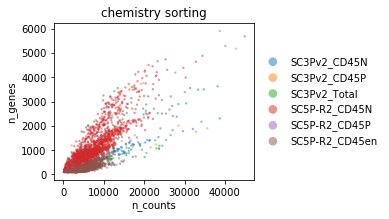

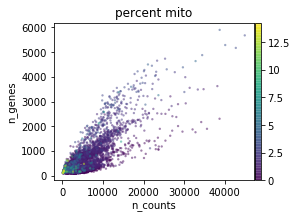

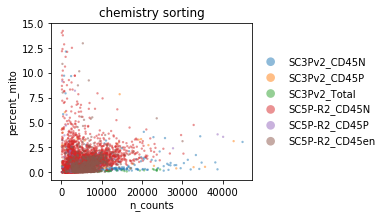

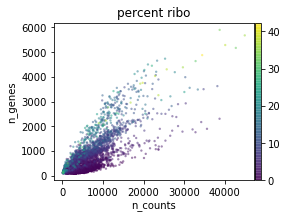

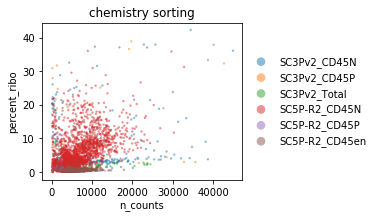

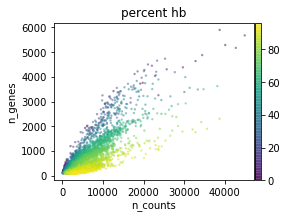

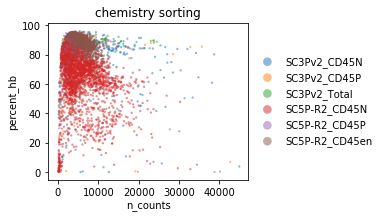

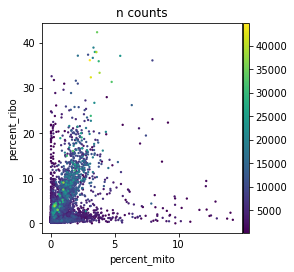

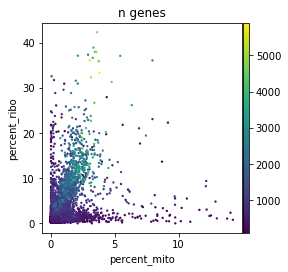

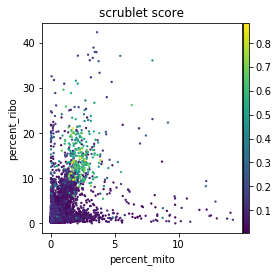

In [8]:
ss.lib.set_figsize((4,4))
ss.lib.simple_default_pipeline(ad, qc_only=True, batch='chemistry_sorting')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_counts')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='n_genes')
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='scrublet_score')

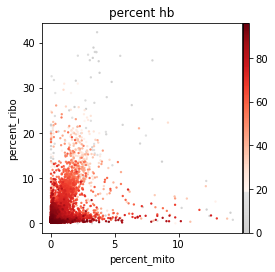

In [25]:
sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='percent_hb', color_map=ss.lib.expression_colormap(0.2))

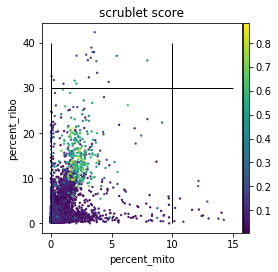

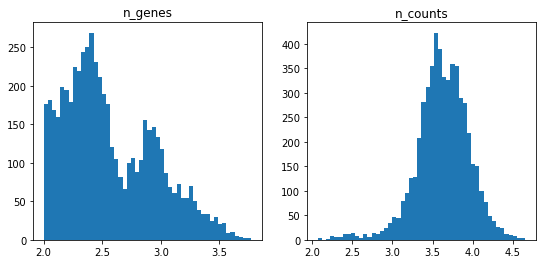

In [26]:
ss.lib.set_figsize((4,4))
ax = sc.pl.scatter(ad, x='percent_mito', y='percent_ribo', color='scrublet_score', show=False)
ax.vlines(x=[0, 10], ymin=0, ymax=40, linewidth=1)
ax.hlines(y=30, xmin=0, xmax=15, linewidth=1)
ss.lib.set_figsize((9,4))
fig, ax = plt.subplots(ncols=2)
_ = ax[0].hist(np.log10(ad.obs.loc[ad.obs['percent_mito']<10, 'n_genes']), bins=50)
ax[0].set_title('n_genes')
_ = ax[1].hist(np.log10(ad.obs.loc[ad.obs['percent_mito']<10, 'n_counts']), bins=50)
ax[1].set_title('n_counts')
ss.lib.set_figsize((4,4))

# 3. Default preprocessing

In [27]:
MIN_PCT_MITO = 0
MAX_PCT_MITO = 10
MAX_PCT_RIBO = 30
MIN_N_GENE = 200
MIN_N_UMI = 1000
MIN_PCT_HB = 20
MIN_N_CELL = 3
CLUSTER_RESOLUTIONS = [0.1, 0.2, 0.3, 0.4, 0.5]

In [28]:
ad = ad[
    (ad.obs.percent_mito >= MIN_PCT_MITO) &
    (ad.obs.percent_mito < MAX_PCT_MITO) &
    (ad.obs.percent_ribo < MAX_PCT_RIBO) &
    (ad.obs.n_genes >= MIN_N_GENE) &
    (ad.obs.n_counts >= MIN_N_UMI) &
    (ad.obs.percent_hb >= MIN_PCT_HB), :]
ad = ad[:, (ad.var.n_cells >= MIN_N_CELL)]

In [63]:
ad1 = ad.copy()[:, ~(ad.var.mito | ad.var.hb | ad.var.ribo)]

ss.lib.simple_default_pipeline(
    ad1,
    filter_params=None,
    hvg_params={'flavor': 'seurat', 'by_batch': ['chemistry', 2]},
    scale_params={'max_value': 10},
    pca_params={'n_comps': 50, 'svd_solver': 'arpack', 'use_highly_variable': True},
    harmony_params=None,
    nb_params={'use_rep': 'X_pca', 'key_added': 'orig'},
    umap_params={'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

k_annot = (ad1.obs['annot'] != 'nan').values
ad1.obs['lr_annot'] = ss.lib.LR_annotate(
    ad1, train_label=ad1.obs['annot'].values, train_x=ad1.obsm['X_pca'], subset=k_annot, use_rep='X_pca', return_label=True)
ad1.obs['lr_annot'] = ad1.obs['lr_annot'].astype('category')

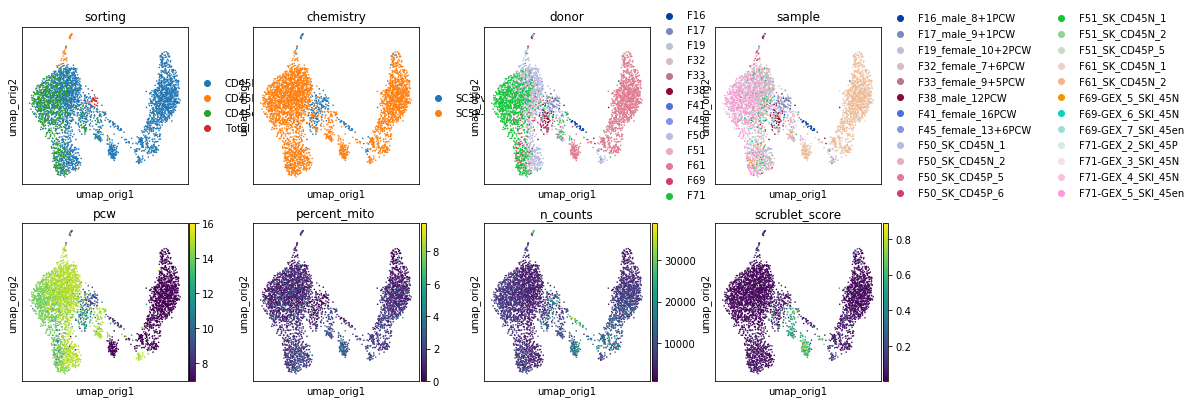

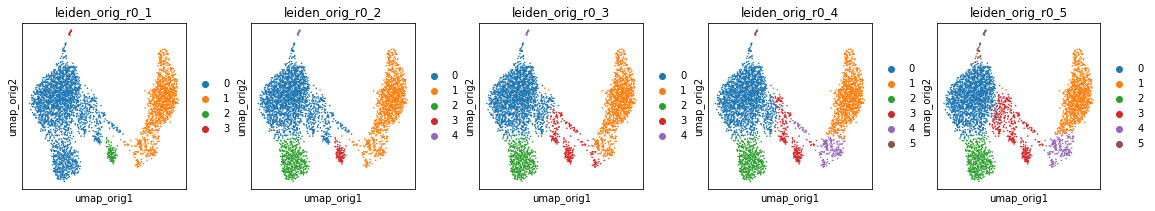

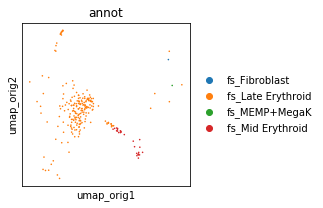

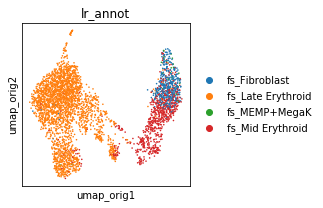

                      freq     p
leiden_orig_r0_3                
0                 0.013001  0.00
1                 0.000888  0.75
2                 0.000000  0.75
3                 0.643636  0.00
4                 0.000000  0.75
                     score         p
leiden_orig_r0_3                    
0                 0.033610  0.750000
1                 0.038382  0.750000
2                 0.042508  0.750000
3                 0.409439  0.000000
4                 0.094567  0.000099


In [64]:
ad1.obs['doublet'] = ad1.obs['bh_doublet_pval'] < 0.05
ad1.obs['doublet'] = ad1.obs['doublet'].astype('category')
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_orig', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_orig', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_orig_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(
    ad1[k_annot, :], basis='umap_orig', size=10,
    color='annot')
plot_scatter(
    ad1, basis='umap_orig', size=10,
    color='lr_annot')

doublet_freq = ad1.obs.groupby('leiden_orig_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_orig_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

In [66]:
ad2 = ad.copy()[:,~(ad.var.mito | ad.var.hb | ad.var.ribo | ad.var.cc)]

ss.lib.simple_default_pipeline(
    ad2,
    filter_params=None,
    hvg_params={'flavor': 'seurat', 'by_batch': ['chemistry', 2]},
    scale_params={'max_value': 10},
    pca_params={'n_comps': 50, 'svd_solver': 'arpack', 'use_highly_variable': True},
    harmony_params=None,
    nb_params={'use_rep': 'X_pca', 'key_added': 'orig'},
    umap_params={'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_orig', 'key_added': 'orig'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

k_annot = (ad2.obs['annot'] != 'nan').values
ad2.obs['lr_annot'] = ss.lib.LR_annotate(
    ad2, train_label=ad2.obs['annot'].values, train_x=ad2.obsm['X_pca'], subset=k_annot, use_rep='X_pca', return_label=True)
ad2.obs['lr_annot'] = ad2.obs['lr_annot'].astype('category')

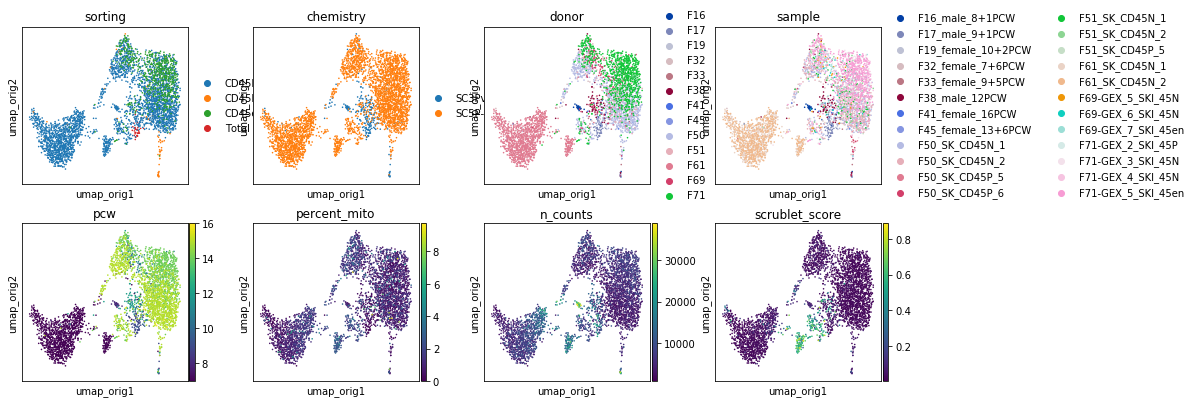

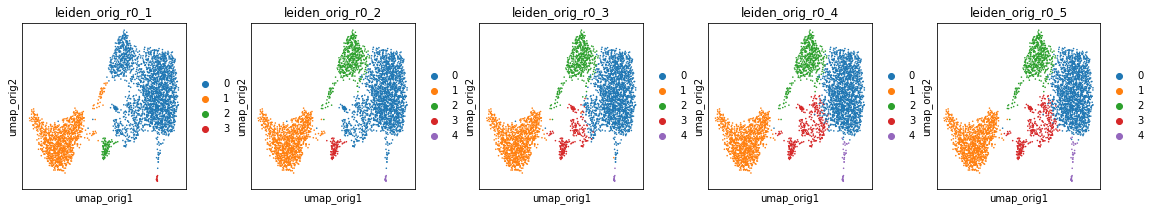

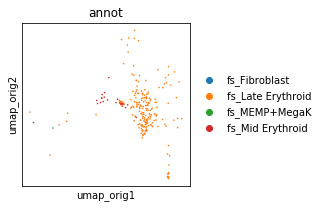

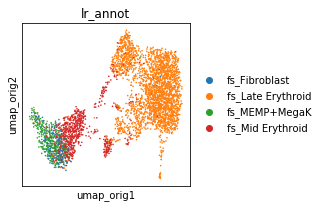

                      freq         p
leiden_orig_r0_3                    
0                 0.013506  0.000169
1                 0.000890  0.750000
2                 0.002028  0.750000
3                 0.723140  0.000000
4                 0.000000  0.750000
                     score         p
leiden_orig_r0_3                    
0                 0.033349  0.750000
1                 0.038571  0.750000
2                 0.051677  0.750000
3                 0.442134  0.000000
4                 0.089887  0.199598


In [67]:
ad2.obs['doublet'] = ad2.obs['bh_doublet_pval'] < 0.05
ad2.obs['doublet'] = ad2.obs['doublet'].astype('category')

ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_orig', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_orig', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_orig_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_orig', size=10, color='annot')
plot_scatter(ad2, basis='umap_orig', size=10, color='lr_annot')


doublet_freq = ad2.obs.groupby('leiden_orig_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_orig_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

# 4.1 Harmony

In [68]:
ss.lib.simple_default_pipeline(
    ad1,
    filter_params=None, norm_params=None, hvg_params=None, scale_params=None, pca_params=None,
    harmony_params={'batch': 'sample', 'key_added': 'hm'},
    nb_params={'use_rep': 'X_pca_hm', 'key_added': 'hm'},
    umap_params={'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 3800 × 15489 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors', 'lr_annot_colors', 'neighbors_hm', 'neighbors'
    obsm: 'X_pca', 'X_umap_orig', 'X_pca_hm', 'X_umap_hm'
    

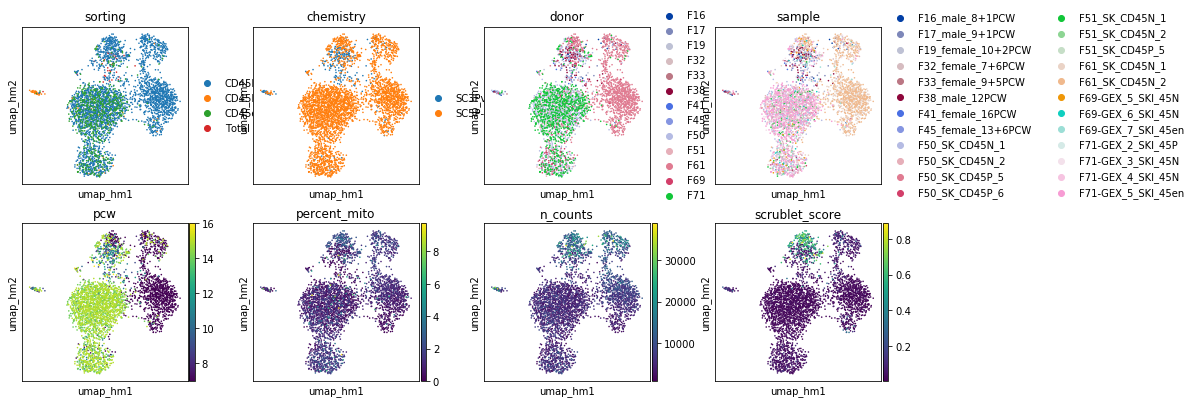

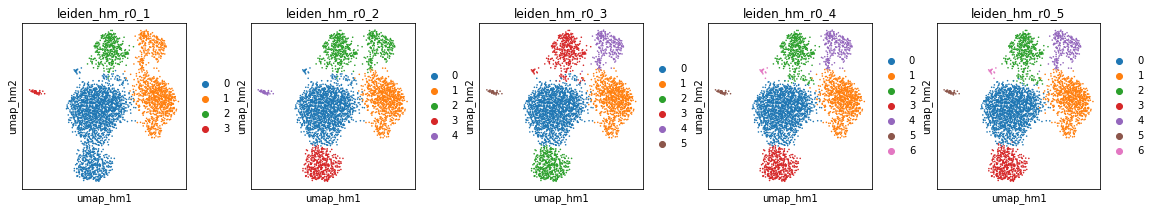

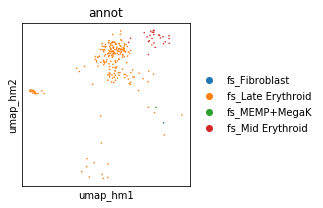

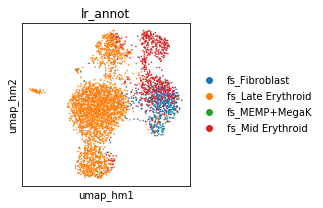

In [69]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_hm', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_hm', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_hm_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad1[k_annot, :], basis='umap_hm', size=10, color='annot')
plot_scatter(ad1, basis='umap_hm', size=10, color='lr_annot')

In [70]:
doublet_freq = ad1.obs.groupby('leiden_hm_r0_3')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_hm_r0_3')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                    freq        p
leiden_hm_r0_3                   
0               0.001159  0.75000
1               0.001155  0.75000
2               0.000000  0.75000
3               0.444196  0.00000
4               0.003676  0.21265
5               0.000000  0.75000
                   score             p
leiden_hm_r0_3                        
0               0.025059  7.999225e-01
1               0.031981  7.999225e-01
2               0.041287  7.999225e-01
3               0.286110  2.819075e-08
4               0.075563  6.656416e-01
5               0.085478  6.656416e-01


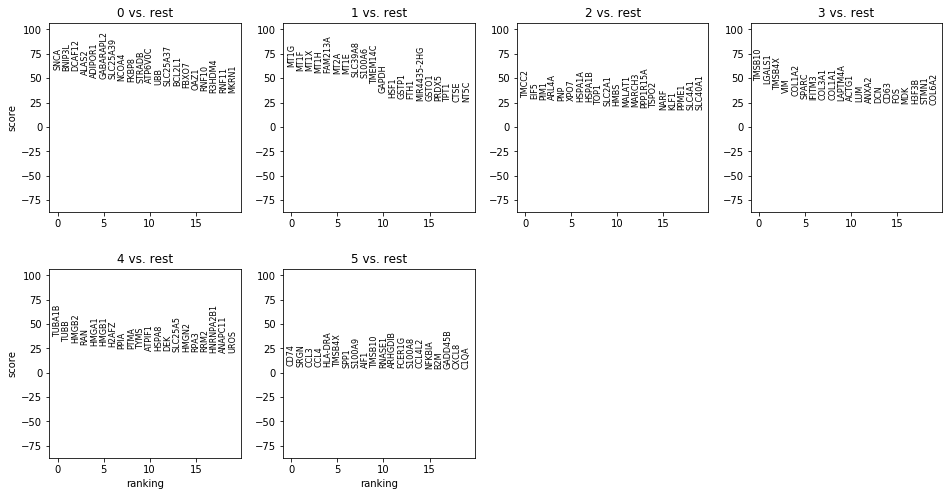

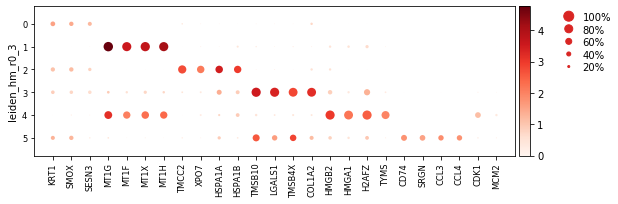

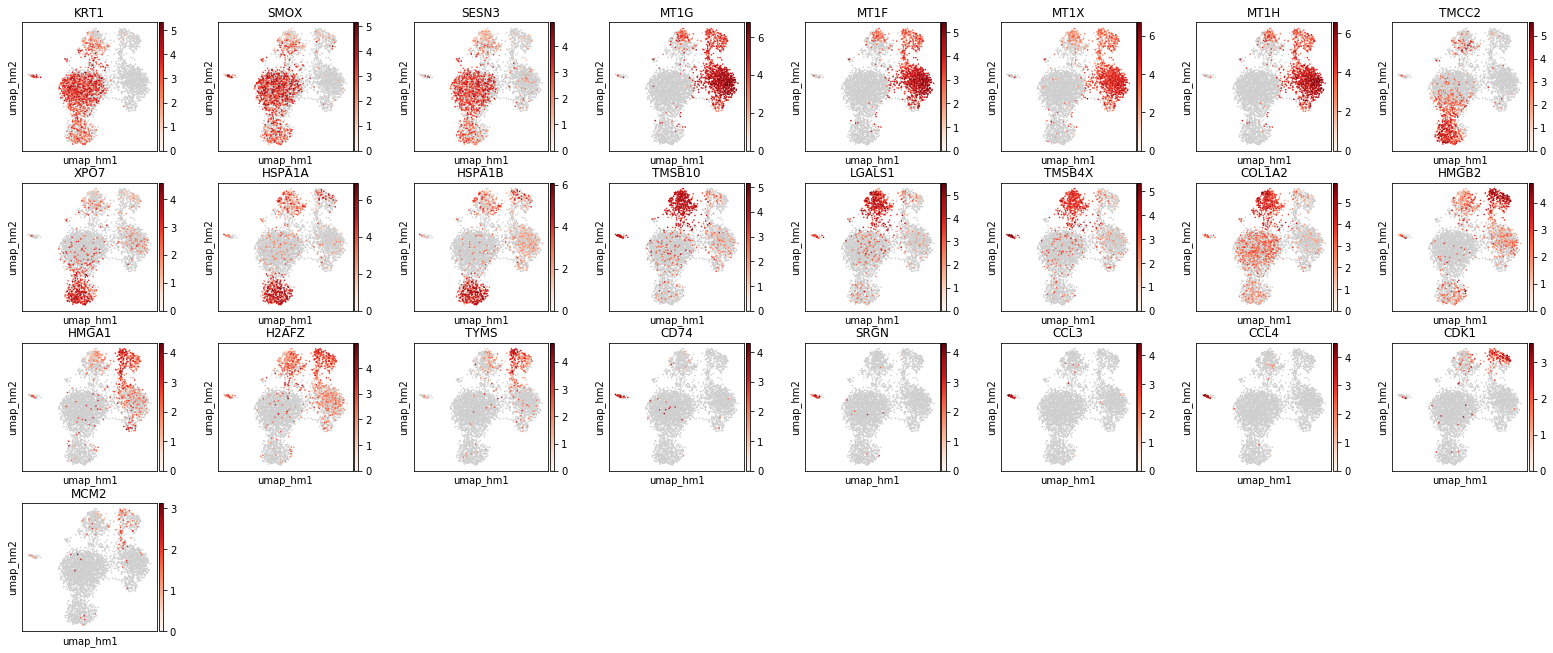

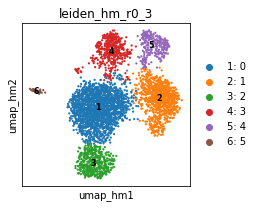

In [73]:
DE_RES = 0.3

hm_de_genes1 = diffexp(
    ad1, basis='umap', key='hm', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=['CDK1', 'MCM2']
)
hm_de_genes1.groupby('cluster').head(5)

res = str(DE_RES).replace(".", "_")
hm_de_genes1.groupby('cluster').head(30).to_csv(
    f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_withCC_leiden_r{res}_DE_filtered_top30.txt', sep='\t', index=False)
ss.lib.extract_de_table(ad1.uns[f'rank_genes_groups_hm_r{res}']).groupby('cluster').head(200).to_csv(
    f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_withCC_leiden_r{res}_DE_top200.txt', sep='\t', index=False)

In [74]:
ss.lib.simple_default_pipeline(
    ad2,
    filter_params=None, norm_params=None, hvg_params=None, scale_params=None, pca_params=None,
    harmony_params={'batch': 'sample', 'key_added': 'hm'},
    nb_params={'use_rep': 'X_pca_hm', 'key_added': 'hm'},
    umap_params={'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    leiden_params={'resolution': CLUSTER_RESOLUTIONS, 'use_graph': 'neighbors_hm', 'key_added': 'hm'},
    tsne_params=None, diffmap_params=None, fdg_params=None,
)

AnnData object with n_obs × n_vars = 3800 × 14927 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors', 'lr_annot_colors', 'neighbors_hm', 'neighbors'
    obsm: 'X_pca', 'X_umap_orig', 'X_pca_hm', 'X_umap_hm'
    

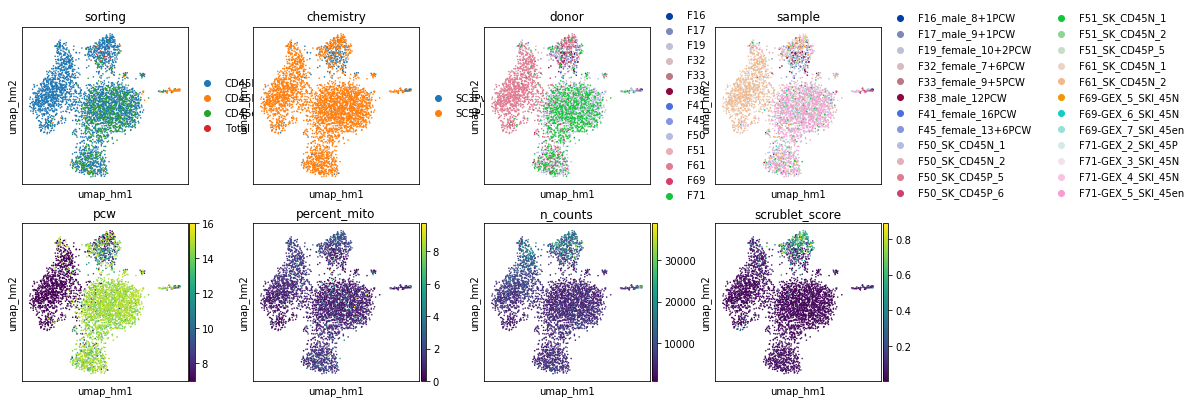

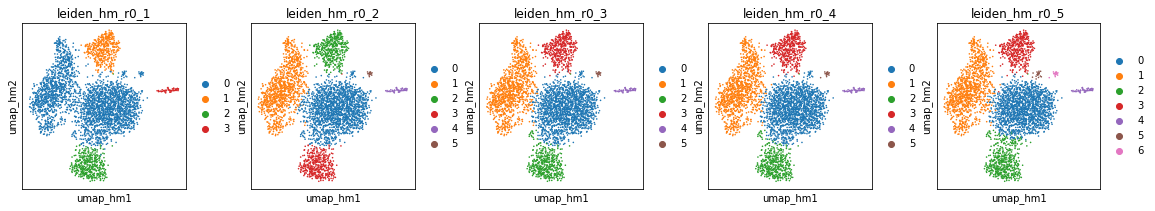

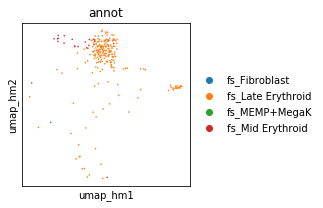

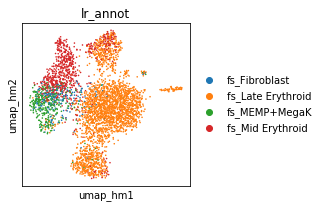

In [75]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_hm', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_hm', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_hm_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_hm', size=10, color='annot')
plot_scatter(ad2, basis='umap_hm', size=10, color='lr_annot')

In [76]:
doublet_freq = ad2.obs.groupby('leiden_hm_r0_2')['doublet'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_hm_r0_2')['scrublet_score'].agg(lambda x: sum(x)/len(x))
_, p = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                    freq         p
leiden_hm_r0_2                    
0               0.001120  0.499999
1               0.001840  0.185078
2               0.455378  0.000000
3               0.000000  0.750000
4               0.000000  0.750000
5               0.000000  0.750000
                   score         p
leiden_hm_r0_2                    
0               0.026027  0.882029
1               0.041380  0.852705
2               0.292079  0.000000
3               0.041517  0.852705
4               0.074249  0.582681
5               0.068294  0.582681


cluster   ref  rank      genes     scores  logfoldchanges  \
38          0  rest    38       KRT1  22.384872        2.584344   
14927       1  rest     0       MT1G  68.810265        7.913496   
14928       1  rest     1       MT2A  66.034996        6.914313   
14929       1  rest     2       MT1X  62.489071        6.742468   
14930       1  rest     3       MT1E  62.300148        6.739664   
14931       1  rest     4       MT1F  61.443829        6.804595   
29854       2  rest     0     TMSB10  55.694283        6.900027   
29855       2  rest     1     LGALS1  48.816212        7.005275   
29856       2  rest     2     TMSB4X  41.551865        6.083887   
29858       2  rest     4     COL1A2  35.183594        5.235792   
29860       2  rest     6      SPARC  31.580059        5.005805   
44781       3  rest     0      TMCC2  29.995577        5.421328   
44784       3  rest     3     HSPA1A  26.896729        6.186922   
44786       3  rest     5       XPO7  26.832123        5.014945   
44787       3  rest     6     HSPA1B  26.201942        5.546316   
44791       3  rest    10     MARCH3  21.041590        3.704146   
59708       4  rest     0       CD74   6.766820        8.096307   
59709       4  rest     1       SRGN   6.257282        9.023870   
59710       4  rest     2    ARHGDIB   6.025065        7.800059   
59711       4  rest     3       CCL4   5.898494        9.521321   
59712       4  rest     4       CCL3   5.783885        9.169856   
74635       5  rest     0       IFI6   7.855514        7.995150   
74636       5  rest     1      ISG15   5.148577        7.796852   
74637       5  rest     2  C20orf196   1.965233        2.319818   
74654       5  rest    19      UBE2H   1.555263        1.779196   

               pvals      pvals_adj  
38     1.180866e-102  6.601792e-101  
14927   0.000000e+00   0.000000e+00  
14928   0.000000e+00   0.000000e+00  
14929   0.000000e+00   0.000000e+00  
14930   0.000000e+00   0.000000e+00  
14931   0.000000e+00   0.000000e+00  
29854  1.337845e-288  1.997001e-284  
29855  9.794175e-238  7.309883e-234  
29856  1.768306e-202  8.798500e-199  
29858  2.658409e-169  7.936414e-166  
29860  5.292954e-144  1.128685e-140  
44781  4.751618e-129  7.092740e-125  
44784  9.440419e-107  2.013102e-103  
44786  6.763148e-107  1.682558e-103  
44787  1.124984e-102   2.099080e-99  
44791   1.720834e-77   2.140574e-74  
59708   1.635898e-08   2.441905e-04  
59709   1.046926e-07   7.813736e-04  
59710   2.301312e-07   1.145056e-03  
59711   3.754439e-07   1.381050e-03  
59712   5.551215e-07   1.381050e-03  
74635   5.362037e-07   8.003913e-03  
74636   1.013992e-04   7.567930e-01  
74637   6.048573e-02   9.595099e-01  
74654   1.313678e-01   9.595099e-01

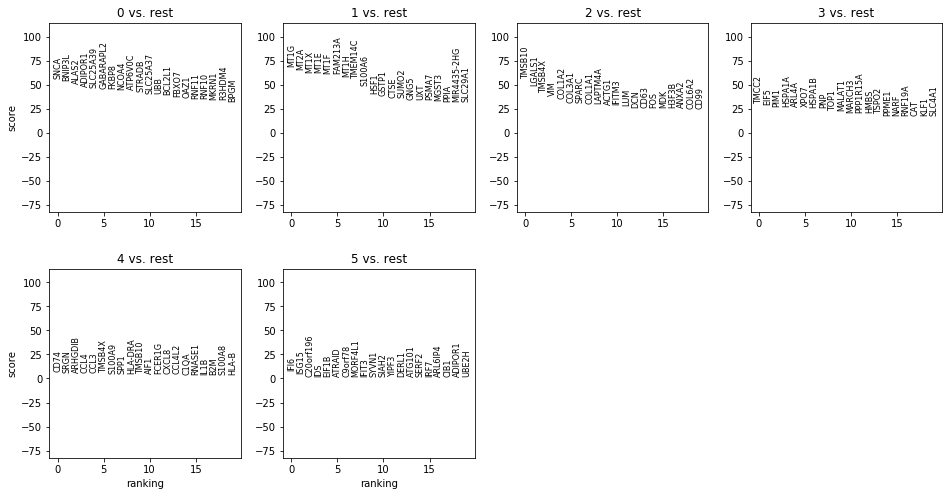

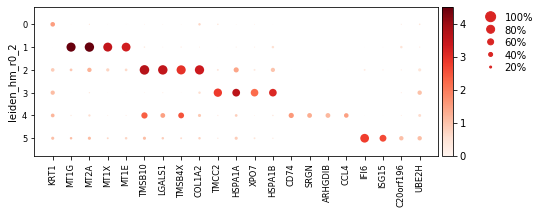

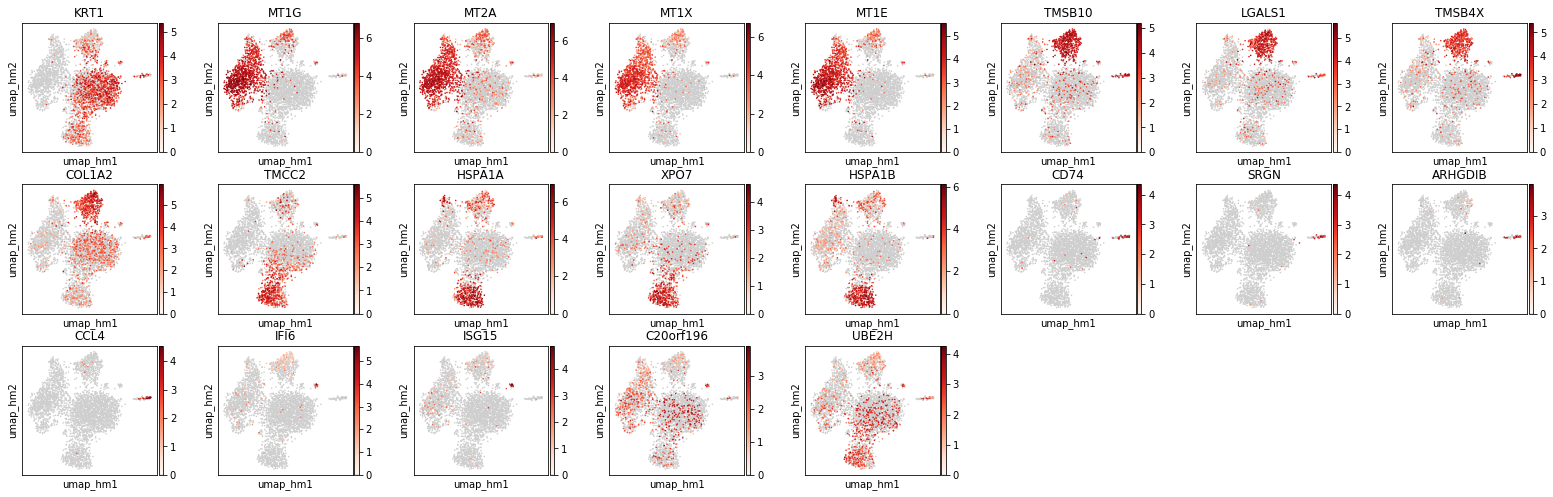

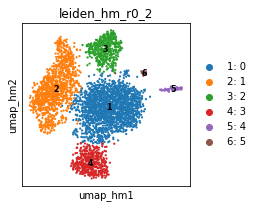

In [78]:
DE_RES = 0.2

hm_de_genes2 = diffexp(
    ad2, basis='umap', key='hm', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=None
)
hm_de_genes2.groupby('cluster').head(5)

# res = str(DE_RES).replace(".", "_")
# hm_de_genes2.groupby('cluster').head(30).to_csv(
#     f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_noCC_leiden_r{res}_DE_filtered_top30.txt', sep='\t', index=False)
# ss.lib.extract_de_table(ad2.uns[f'rank_genes_groups_hm_r{res}']).groupby('cluster').head(200).to_csv(
#     f'2.{CATEGORY_CLUSTER_ID+1}_{CATEGORY_NAME}_harmony_noCC_leiden_r{res}_DE_top200.txt', sep='\t', index=False)

# 4.2 BBKNN

In [79]:
ad1.uns['neighbors'] = ad1.uns['neighbors_orig']
bbknn.bbknn(ad1, batch_key='sample', metric='euclidean', neighbors_within_batch=2, trim=15, copy=False)
ad1.uns['neighbors_bk'] = ad1.uns['neighbors']
ss.lib.umap(ad1, use_graph='neighbors_bk', key_added='bk')
ss.lib.leiden(ad1, use_graph='neighbors_bk', key_added='bk', resolution=CLUSTER_RESOLUTIONS)

AnnData object with n_obs × n_vars = 3800 × 15489 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors'

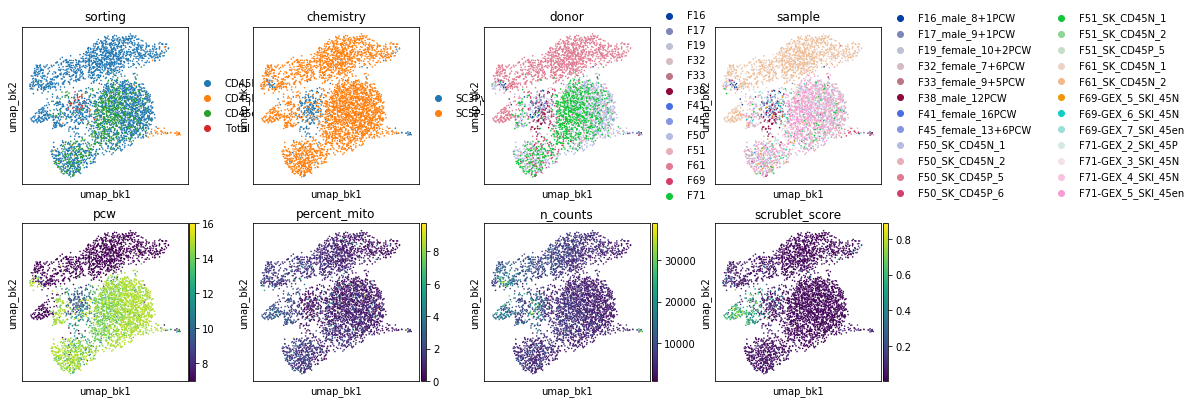

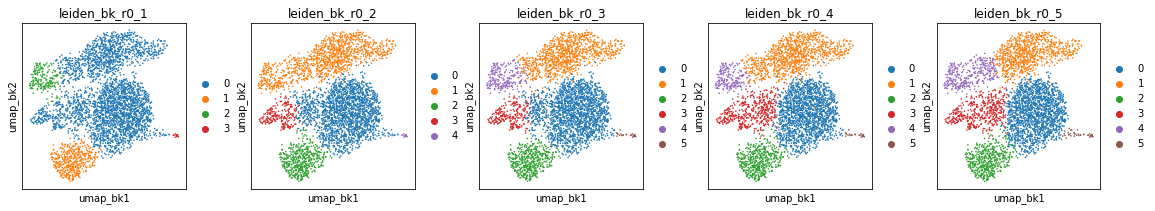

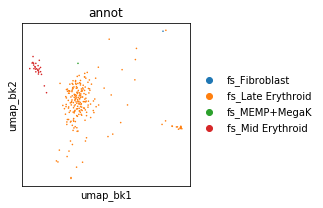

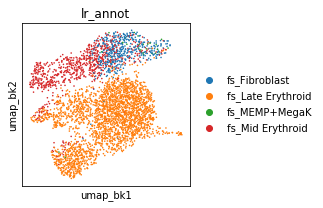

                    freq         p
leiden_bk_r0_2                    
0               0.012513  0.000402
1               0.001704  0.550290
2               0.002096  0.500000
3               0.814815  0.000000
4               0.000000  0.750000
                   score         p
leiden_bk_r0_2                    
0               0.033545  0.750000
1               0.042623  0.510381
2               0.042988  0.500000
3               0.486850  0.000000
4               0.094567  0.000115


In [80]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad1, basis='umap_bk', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad1, basis='umap_bk', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_bk_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad1[k_annot, :], basis='umap_bk', size=10, color='annot')
plot_scatter(ad1, basis='umap_bk', size=10, color='lr_annot')


doublet_freq = ad1.obs.groupby('leiden_bk_r0_2')['doublet'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad1.obs.groupby('leiden_bk_r0_2')['scrublet_score'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

cluster   ref  rank    genes     scores  logfoldchanges          pvals  \
39          0  rest    39     KRT1  23.464922        2.777435  6.232485e-111   
47          0  rest    47     SMOX  20.389801        2.468726   3.990727e-86   
49          0  rest    49    SESN3  19.809662        2.380527   1.609167e-81   
15489       1  rest     0     MT1G  62.717300        7.433660   0.000000e+00   
15490       1  rest     1     MT1F  59.093178        6.440855   0.000000e+00   
15491       1  rest     2     MT1X  58.295795        6.370529   0.000000e+00   
15492       1  rest     3     MT1H  57.113602        7.032570   0.000000e+00   
15494       1  rest     5  FAM213A  53.569511        5.368830   0.000000e+00   
30978       2  rest     0    TMCC2  32.339260        5.580969  3.380252e-146   
30983       2  rest     5     XPO7  26.388285        4.923053  7.405203e-107   
30984       2  rest     6   HSPA1A  25.438038        5.794045  2.110652e-101   
30985       2  rest     7   HSPA1B  24.319458        5.140604   8.377718e-95   
30987       2  rest     9   MARCH3  20.760296        3.557278   2.077436e-77   
46467       3  rest     0   TMSB10  46.536873        6.630661  4.863234e-231   
46468       3  rest     1   LGALS1  42.527695        6.750368  2.736934e-198   
46469       3  rest     2   TMSB4X  38.834690        5.992969  2.425374e-183   
46472       3  rest     5    SPARC  29.201176        4.823587  1.563039e-128   
46476       3  rest     9   IFITM3  27.690479        6.170199  1.932274e-105   
61960       4  rest     4    HMGA1  30.724619        5.217447  9.273181e-122   
61963       4  rest     7    H2AFZ  27.120211        4.404508  5.151077e-109   
61966       4  rest    10    HMGB2  26.006126        5.045285   5.209725e-97   
61975       4  rest    19      DEK  23.246653        4.077017   8.823413e-86   
61976       4  rest    20     TYMS  23.157953        5.862919   3.910048e-76   
77445       5  rest     0     CD74   8.560466        9.240573   9.696841e-11   
77446       5  rest     1     SRGN   6.044103        8.851511   3.555476e-07   
77447       5  rest     2     CCL4   5.800935        9.483089   8.116257e-07   
77448       5  rest     3  HLA-DRA   5.740689        9.715278   9.844686e-07   
77449       5  rest     4     CCL3   5.635799        9.083046   1.380520e-06   

           pvals_adj  
39     4.233990e-109  
47      1.493052e-84  
49      5.465874e-80  
15489   0.000000e+00  
15490   0.000000e+00  
15491   0.000000e+00  
15492   0.000000e+00  
15494   0.000000e+00  
30978  5.235672e-142  
30983  1.911653e-103  
30984   4.670270e-98  
30985   1.622031e-91  
30987   2.925219e-74  
46467  7.532664e-227  
46468  2.119618e-194  
46469  1.252220e-179  
46472  3.458559e-125  
46476  2.720818e-102  
61960  2.872646e-118  
61963  9.973130e-106  
61966   6.724453e-94  
61975   7.192939e-83  
61976   1.781257e-73  
77445   1.501944e-06  
77446   2.753539e-03  
77447   3.812108e-03  
77448   3.812108e-03  
77449   4.276576e-03

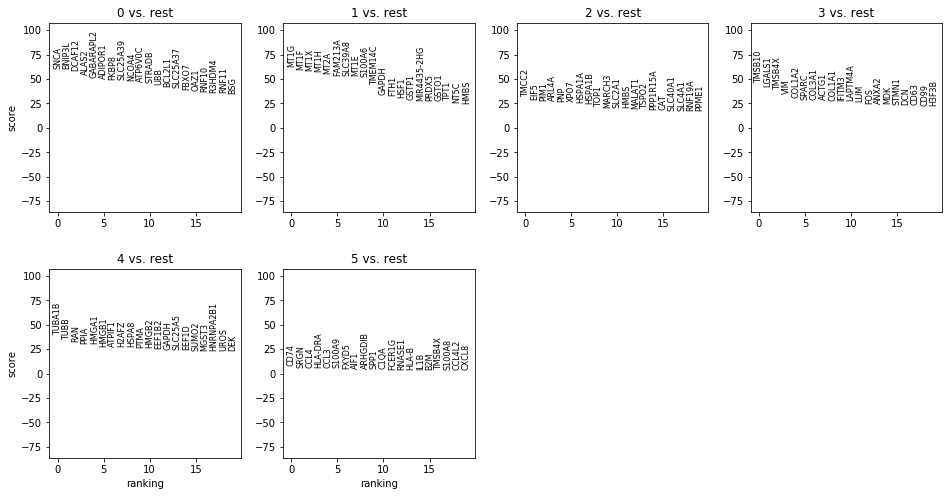

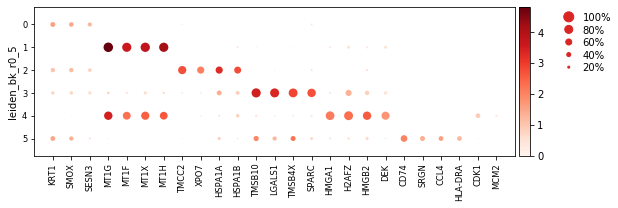

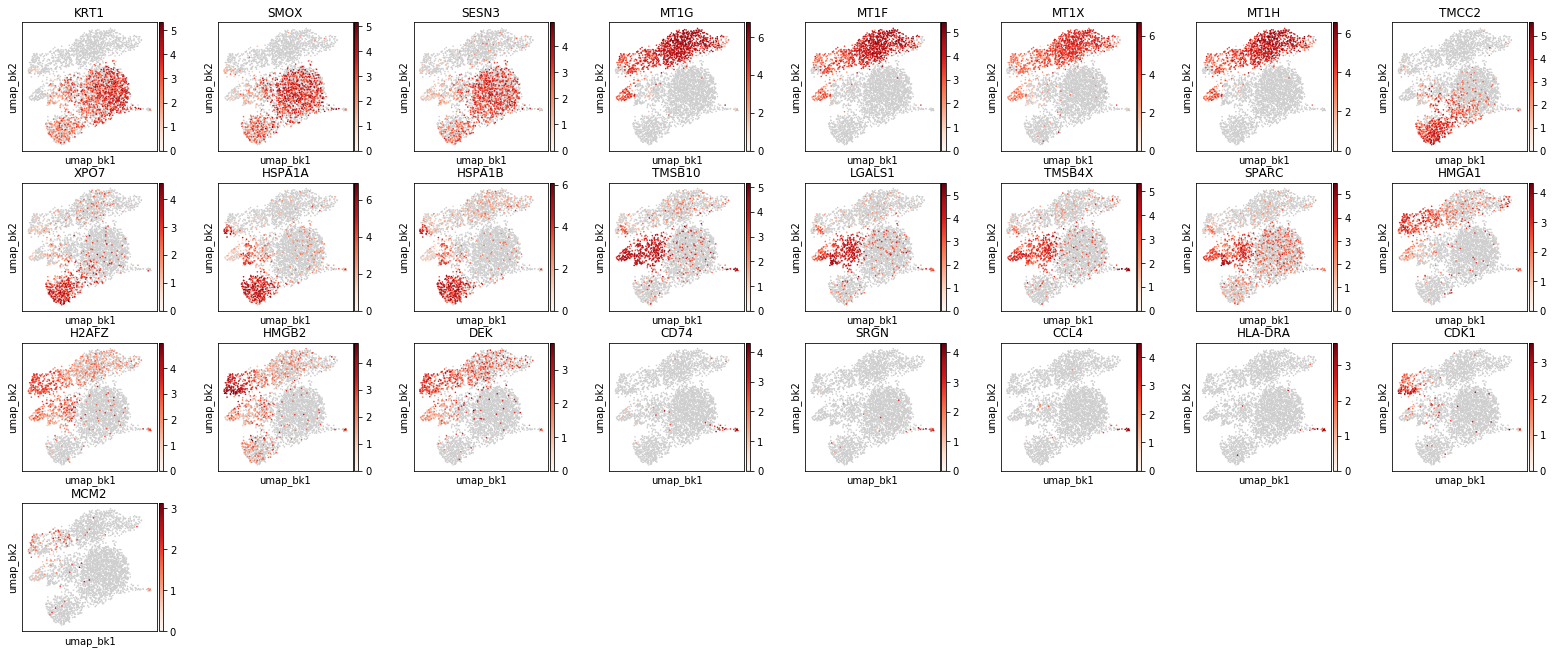

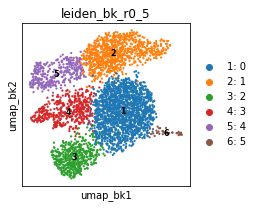

In [88]:
DE_RES = 0.5

bk_de_genes1 = diffexp(
    ad1, basis='umap', key='bk', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=['CDK1', 'MCM2']
)
bk_de_genes1.groupby('cluster').head(5)

In [82]:
ad2.uns['neighbors'] = ad2.uns['neighbors_orig']
bbknn.bbknn(ad2, batch_key='sample', metric='euclidean', neighbors_within_batch=2, trim=15, copy=False)
ad2.uns['neighbors_bk'] = ad2.uns['neighbors']
ss.lib.umap(ad2, use_graph='neighbors_bk', key_added='bk')
ss.lib.leiden(ad2, use_graph='neighbors_bk', key_added='bk', resolution=CLUSTER_RESOLUTIONS)

AnnData object with n_obs × n_vars = 3800 × 14927 
    obs: 'bh_doublet_pval', 'cell_caller', 'cluster_scrublet_score', 'doublet_pval', 'mt_prop', 'n_counts', 'n_genes', 'sanger_id', 'scrublet_score', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'annot', 'hierarchy1', 'percent_mito', 'percent_ribo', 'percent_hb', 'leiden_orig_r0_1', 'leiden_orig_r0_2', 'leiden_orig_r0_3', 'leiden_orig_r0_4', 'leiden_orig_r0_5', 'lr_annot', 'doublet', 'leiden_hm_r0_1', 'leiden_hm_r0_2', 'leiden_hm_r0_3', 'leiden_hm_r0_4', 'leiden_hm_r0_5', '__is_in_cluster__', 'leiden_bk_r0_1', 'leiden_bk_r0_2', 'leiden_bk_r0_3', 'leiden_bk_r0_4', 'leiden_bk_r0_5'
    var: 'gene_ids', 'cc', 'mito', 'ribo', 'hb', 'n_cells', 'highly_variable'
    uns: 'pca', 'neighbors_orig', 'leiden', 'sorting_colors', 'chemistry_colors', 'donor_colors', 'sample_colors', 'leiden_orig_r0_1_colors', 'leiden_orig_r0_2_colors', 'leiden_orig_r0_3_colors', 'leiden_orig_r0_4_colors', 'leiden_orig_r0_5_colors'

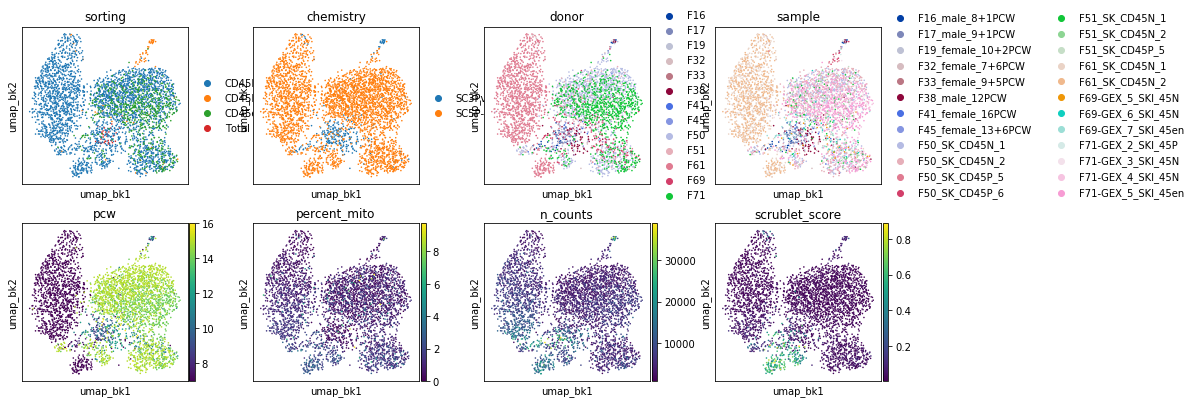

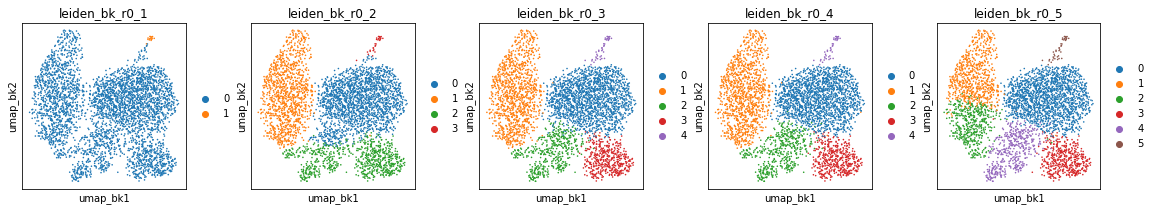

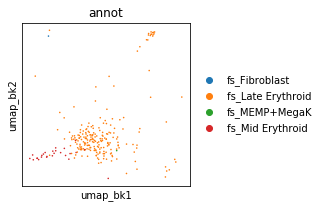

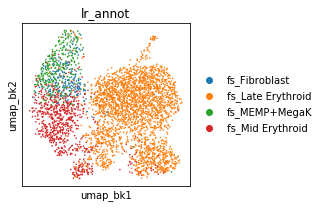

In [83]:
ss.lib.set_figsize((3,3))
plot_scatter(
    ad2, basis='umap_bk', size=10,
    color=['sorting', 'chemistry', 'donor', 'sample', 'pcw', 'percent_mito', 'n_counts', 'scrublet_score'])
plot_scatter(
    ad2, basis='umap_bk', size=10, ncols=len(CLUSTER_RESOLUTIONS),
    color=[f'leiden_bk_r{str(res).replace(".", "_")}' for res in CLUSTER_RESOLUTIONS])
plot_scatter(ad2[k_annot, :], basis='umap_bk', size=10, color='annot')
plot_scatter(ad2, basis='umap_bk', size=10, color='lr_annot')

In [85]:
doublet_freq = ad2.obs.groupby('leiden_bk_r0_5')['doublet'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'freq': doublet_freq, 'p': p}))

doublet_freq = ad2.obs.groupby('leiden_bk_r0_5')['scrublet_score'].agg(lambda x: sum(x)/len(x))
p, p_adj = ss.lib.test_outlier(doublet_freq, upper_mad_only=False)
print(pd.DataFrame({'score': doublet_freq, 'p': p}))

                    freq     p
leiden_bk_r0_5                
0               0.000600  0.25
1               0.000000  0.75
2               0.004141  0.00
3               0.000000  0.75
4               0.441501  0.00
5               0.000000  0.75
                   score             p
leiden_bk_r0_5                        
0               0.024672  7.668439e-01
1               0.028655  7.325321e-01
2               0.061422  3.943054e-01
3               0.041649  6.056946e-01
4               0.282198  1.985236e-10
5               0.082787  1.983597e-01


cluster   ref  rank    genes     scores  logfoldchanges          pvals  \
37          0  rest    37     KRT1  23.388376        2.761110  1.847005e-110   
46          0  rest    46     SMOX  20.269604        2.445141   2.604451e-85   
48          0  rest    48    SESN3  19.926138        2.385232   1.791243e-82   
14927       1  rest     0     MT1G  48.467113        6.857598  4.124844e-296   
14928       1  rest     1     MT1X  45.733437        5.826557  1.333496e-277   
14929       1  rest     2     MT1H  45.096336        6.443581  7.933922e-272   
14930       1  rest     3     MT1F  44.861607        5.779306  7.818688e-270   
14933       1  rest     6  FAM213A  41.014053        4.765986  8.118365e-240   
29855       2  rest     1   ATPIF1  30.061228        4.026502  1.545869e-140   
29861       2  rest     7     PKLR  26.649940        4.318221  2.417738e-113   
29865       2  rest    11    HMGA1  25.077745        4.700471   3.791578e-99   
29867       2  rest    13     UROS  24.384230        3.494065  1.778261e-102   
29872       2  rest    18    TUBB6  22.727390        3.438163   2.230778e-91   
44781       3  rest     0    TMCC2  32.124538        5.578183  4.394048e-144   
44786       3  rest     5     XPO7  26.675800        4.982043  1.321434e-107   
44787       3  rest     6   HSPA1A  26.334129        6.004940  1.614587e-105   
44788       3  rest     7   HSPA1B  24.981234        5.304412   1.173173e-97   
44791       3  rest    10   MARCH3  20.731449        3.595589   8.735656e-77   
59708       4  rest     0   TMSB10  47.536983        6.683403  2.611524e-239   
59709       4  rest     1   LGALS1  44.973637        6.884865  2.711992e-214   
59710       4  rest     2   TMSB4X  39.743382        6.027475  2.623481e-191   
59712       4  rest     4   COL1A2  32.405373        5.064635  3.073488e-152   
59713       4  rest     5    SPARC  31.102266        4.960989  9.096152e-142   
74635       5  rest     0     CD74   8.103855        9.022205   2.490195e-10   
74636       5  rest     1     SRGN   6.154118        8.957797   1.909242e-07   
74637       5  rest     2     CCL4   5.874795        9.537770   5.044900e-07   
74638       5  rest     3     CCL3   5.757600        9.209498   7.442433e-07   
74639       5  rest     4  HLA-DRA   5.602674        9.633777   1.261621e-06   

           pvals_adj  
37     1.219922e-108  
46      9.482107e-84  
48      6.076790e-81  
14927  6.157155e-292  
14928  9.952546e-274  
14929  3.947655e-268  
14930  2.917739e-266  
14933  1.731183e-236  
29855  1.153760e-136  
29861  4.009953e-110  
29865   3.537306e-96  
29867   1.896007e-99  
29872   1.585658e-88  
44781  6.558996e-140  
44786  3.287508e-104  
44787  3.442991e-102  
44788   2.188995e-94  
44791   1.185429e-73  
59708  3.898222e-235  
59709  2.024096e-210  
59710  1.305357e-187  
59712  9.175591e-149  
59713  2.262971e-138  
74635   3.717115e-06  
74636   1.424963e-03  
74637   2.510174e-03  
74638   2.655331e-03  
74639   3.138702e-03

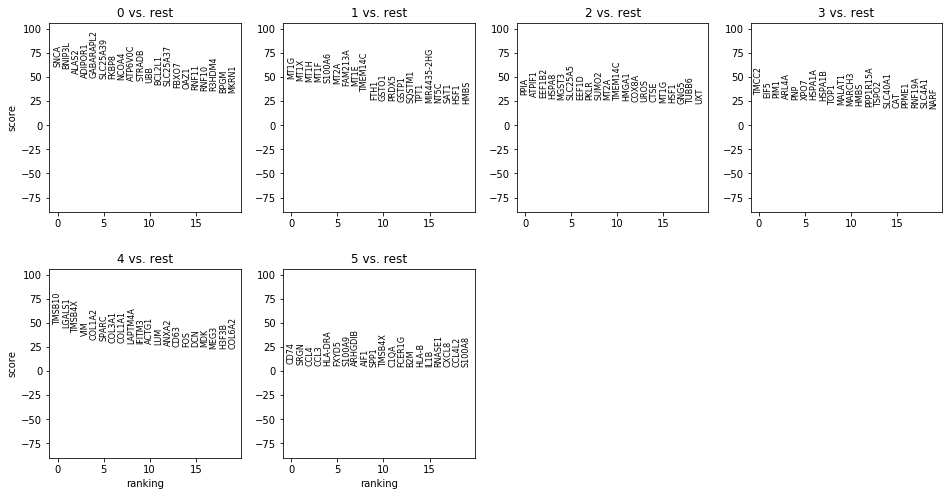

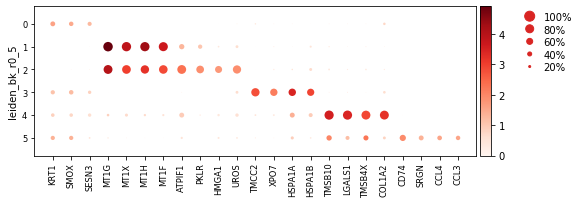

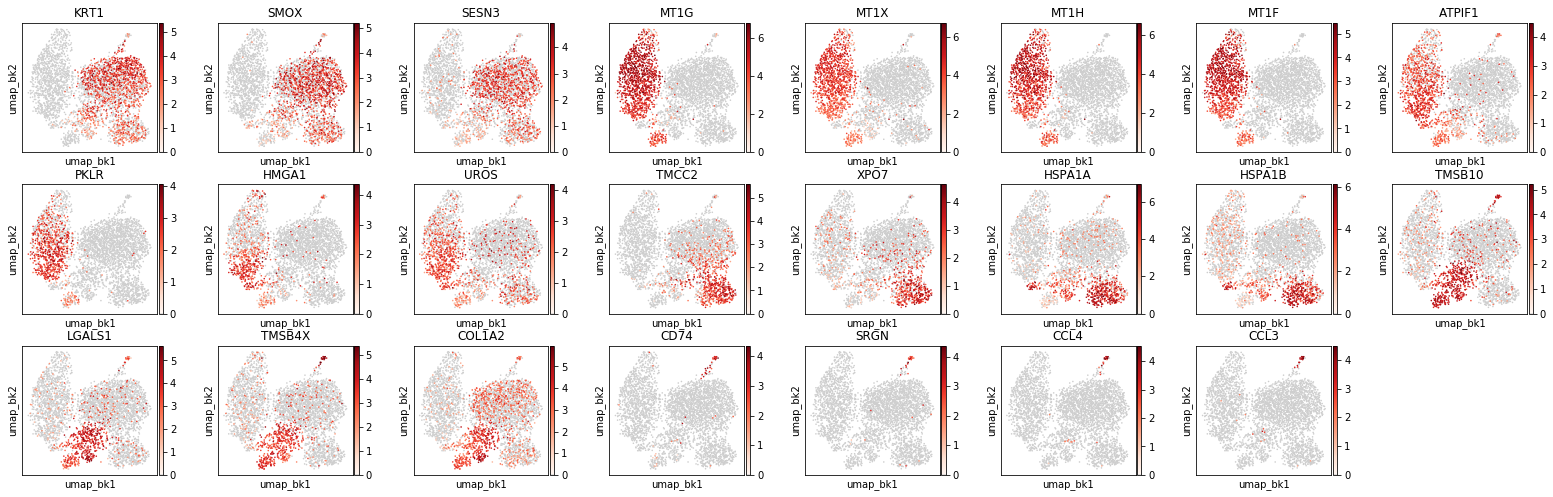

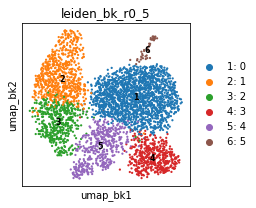

In [87]:
DE_RES = 0.5

bk_de_genes2 = diffexp(
    ad2, basis='umap', key='bk', res=DE_RES, method=DE_METHOD,
    filter_params=DE_FILTERS,
    extra_genes=None
)
bk_de_genes2.groupby('cluster').head(5)

# 5. Combine clustering and embeddings

In [89]:
ad1.obsm['X_umap_hm_nocc'] = ad2.obsm['X_umap_hm']
ad1.obsm['X_umap_bk_nocc'] = ad2.obsm['X_umap_bk']
for res in CLUSTER_RESOLUTIONS:
    r = str(res).replace(".", "_")
    ad1.obs[f'leiden_hm_nocc_r{r}'] = ad2.obs[f'leiden_hm_r{r}']
    ad1.obs[f'leiden_bk_nocc_r{r}'] = ad2.obs[f'leiden_bk_r{r}']

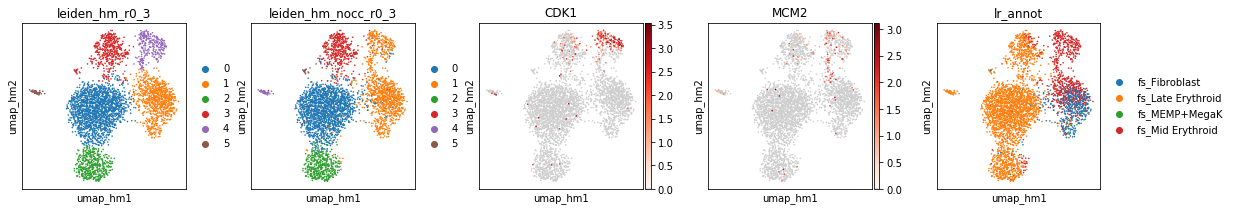

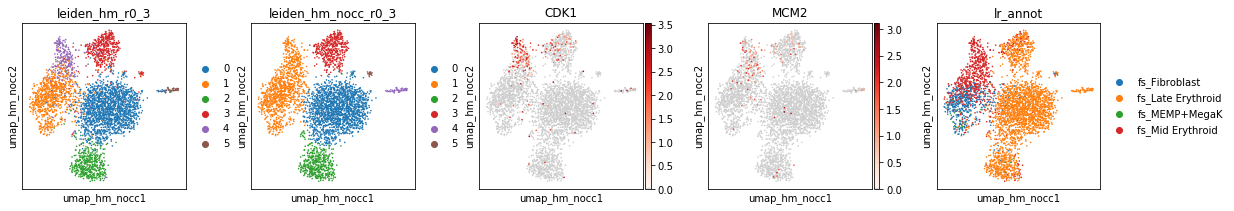

In [92]:
ss.lib.set_figsize((3,3))
plot_scatter(ad1, basis='umap_hm', size=10, color_map=expr_cmap, ncols=5,
             color=['leiden_hm_r0_3', 'leiden_hm_nocc_r0_3', 'CDK1', 'MCM2', 'lr_annot'])
plot_scatter(ad1, basis='umap_hm_nocc', size=10, color_map=expr_cmap, ncols=5,
             color=['leiden_hm_r0_3', 'leiden_hm_nocc_r0_3', 'CDK1', 'MCM2', 'lr_annot'])

In [91]:
ad1.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad', compression='gzip')
ad2.write(f'data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nocc.h5ad', compression='gzip')

In [ ]:
# ad1 = sc.read('data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed.h5ad')
# ad2 = sc.read('data/h5ad/fetal_skin_hierarch1_{CATEGORY_NAME}_processed_nocc.h5ad')